# Generating problem instances
This notebook is used to generate a set of problem instances for the traveling salesman problem with appointment scheduling (TSP-AS).
Per [Issue #47](https://github.com/leonlan/tsp-as/issues/47), we have to generate three types of instances:
1. Small toy instances, which are used to demonstrate examples of edge cases.
2. Medium sized instances, which are used to benchmark.
3. Large sized instances, to show the scalability of our approach.


## Literature
Following the paper by Zhan, Wang and Wan (2022) in EJOR, these are the most important points to mimic:
- Origin is located at (0, 0)
- Customers are located uniformly randomly on a [0, 50]^2 square.
- Travel time between two locations is equal to their Euclidean distance.
- Customer's mean service times $\mu$ are sampled from U(30, 60).
    - Uniform sampled from $U(0, \mu)$.
    - Normal, with $\sigma = 0.5\mu$.

Our `make_random` 

## Experimental setup
Factors and levels
- **Instance size**
    - small (5)
    - medium (15)
    - large (25)
- **Service times**
    - U(30, 60)
    - N(30, $\sigma$)
- **Omegas** (travel, idle, wait): 
    - 0.2/0.2/0.6
    - 0.6/0.2/0.2

## Small example
The code below generates a random instance, saves it as JSON, and loads the JSON as ProblemData instance.

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from tsp_as.classes import ProblemData, Solution
from tsp_as.plot import plot_instance

In [2]:
def make_random(
    seed,
    dim,
    max_size,
    mean_service_time,
    service_distribution,
    min_size=0,
    min_service_time=0,
    distances_scv_min=0.1,
    distances_scv_max=0.1,
    service_scv_min=1.1,
    service_scv_max=1.5,
    coords=None,
    name=None,
    **kwargs,
):
    """
    Creates a random instance with ``dimension`` locations.

    - Customer locations are randomly sampled from a grid of size `max_size`.
    - Travel times are equal to the Euclidean distance.
    - Service times are either uniform or normally distributed.
    - SCVs are sampled uniformly from a provided interval.
    """
    rng = rnd.default_rng(seed)
    name = "Random instance." if name is None else name
    
    if coords is None:
        coords = rng.integers(min_size, max_size, size=(dim, 2))
        coords[0, :] = [0, 0]  # depot location

    distances = pairwise_euclidean(coords)
    distances_scv = rng.uniform(
        low=distances_scv_min,
        high=distances_scv_max,
        size=distances.shape,
    )
    np.fill_diagonal(distances_scv, 0)  # no scv travel time on loops

    if service_distribution == 'uniform':
        service = rng.integers(min_service_time, mean_service_time, size=dim) + 1
    elif service_distribution == 'exponential':
        service = np.maximum(rng.normal(mean_service_time, 0.5*mean_service_time, size=dim), 1)
    else:
        raise ValueError("Service type distribution unknown.")
        
    if 'service_scv' in kwargs and kwargs['service_scv'] is not None:
        service_scv = kwargs['service_scv']
    else:
        service_scv = rng.uniform(
            low=service_scv_min,
            high=service_scv_max,
            size=service.shape,
        )

        
    service[0] = 0  # depot has no service time
    service_scv[0] = 0

    return ProblemData(
        name,
        coords,
        dim,
        distances,
        distances_scv,
        service,
        service_scv,
        # **kwargs,
    )

def pairwise_euclidean(coords: np.ndarray) -> np.ndarray:
    """
    Computes the pairwise Euclidean distance between the passed-in coordinates.

    Parameters
    ----------
    coords
        An n-by-2 array of location coordinates.

    Returns
    -------
    np.ndarray
        An n-by-n Euclidean distances matrix.

    """
    # Subtract each coordinate from every other coordinate
    diff = coords[:, np.newaxis, :] - coords
    square_diff = diff ** 2
    square_dist = np.sum(square_diff, axis=-1)
    return np.sqrt(square_dist)

/Users/leonlan/Dropbox/tsp-as/tsp_as/classes/ProblemData.py:81: RuntimeWarning: invalid value encountered in divide
  scvs = np.divide(_var, np.power(means, 2))


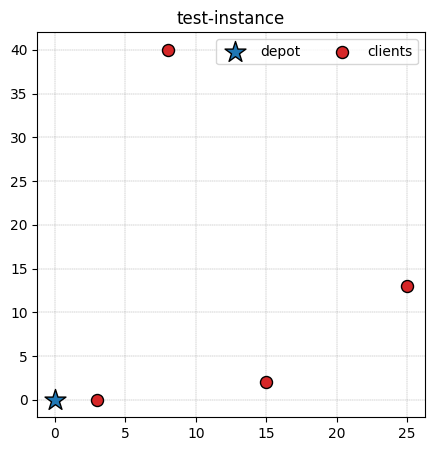

In [3]:
data = make_random(
    seed=0, 
    dim=5, 
    max_size=50, 
    mean_service_time=20,
    service_distribution='uniform',
    distances_scv_min=0.1,
    distances_scv_max=0.5,
    service_scv_min=1.1,
    service_scv_max=1.5,
    name="test-instance"
)
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plot_instance(ax, data)

In [4]:
data_dict = {
    'coords': data.coords,
    'dimension': data.dimension,
    'distances': data.distances,
    'distances_scv': data.distances_scv,
    'service_scv': data.service_scv,
    'service': data.service,
}

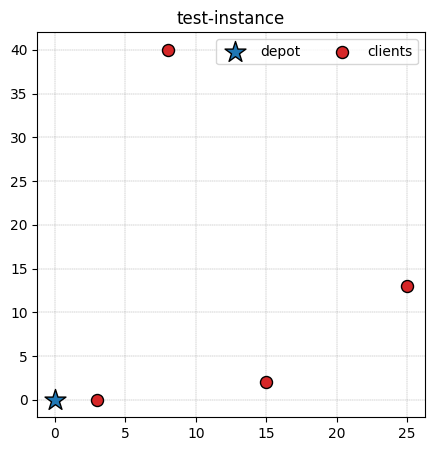

In [5]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return np.round(obj, 3).tolist()
        return json.JSONEncoder.default(self, obj)

def data2dict(data):
    return {
        'coords': data.coords,
        'dimension': data.dimension,
        'distances': data.distances,
        'distances_scv': data.distances_scv,
        'service_scv': data.service_scv,
        'service': data.service,
    }

def save_data(data, out_dir):
    path_dir = Path(out_dir)
    path_dir.mkdir(exist_ok=True, parents=True)
    path_file = path_dir / (data.name + '.json')
 
    with open(path_file, 'w', encoding='utf-8') as fh:
        json.dump(data2dict(data), fh, ensure_ascii=False, indent=4, cls=NumpyEncoder)

# Check that the data is correctly saved and loaded
save_data(data, 'tmp/')
data = ProblemData.from_file('tmp/test-instance.json')    
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plot_instance(ax, data)

## Generate instances

In [31]:
design = {
    'instance_idx': list(range(1)),
    'n_customers': [5, 10, 15, 20, 25, 30, 100],
    'service_distribution': ['uniform'],
    'distances_scv': [(0.15, 0.15)],
    'service_scv': [(0.15, 0.5)],
}

In [32]:
for n_customers in design['n_customers']:
    instance_seed = 0 # Seed counter per instance size to randomize locations
    
    for instance_idx in design['instance_idx']:
        for sd_idx, service_distribution in enumerate(design['service_distribution']):
            for d_idx, distances_scv in enumerate(design['distances_scv']):
                for s_idx, service_scv in enumerate(design['service_scv']):
                    instance_seed += 1 
                    name = f"n{n_customers}-idx{instance_idx}-distribution{sd_idx}-travel{d_idx}-serv{s_idx}"
                    
                    data = make_random(
                        seed=instance_seed, 
                        dim=n_customers+1, 
                        max_size=50, 
                        mean_service_time=60,
                        min_service_time=30,
                        service_distribution=service_distribution,
                        distances_scv_min=distances_scv[0],
                        distances_scv_max=distances_scv[1],
                        service_scv_min=service_scv[0],
                        service_scv_max=service_scv[1],
                        name=name
                    )

                    save_data(data, '../instances/test-speed-expm')
                    # data = ProblemData.from_file(f'../instances/{name}.json')    
                    # fig, ax = plt.subplots(1, 1, figsize=[5, 5])
                    # plot_instance(ax, data)

## Atypical instances

In [ ]:
design = {
    'instance_idx': list(range(1)),
    'n_customers': [30],
    'service_distribution': ['uniform', 'exponential'],
    'distances_scv': [(0.1, 0.5)],
}
for n_customers in design['n_customers']:
    for instance_idx in design['instance_idx']:
        for sd_idx, service_distribution in enumerate(design['service_distribution']):
            for d_idx, distances_scv in enumerate(design['distances_scv']):
                instance_seed = 1 
                name = f"n{n_customers}-idx{instance_idx}-distribution{sd_idx}-travel{d_idx}-servhighlow"

                data = make_random(
                    seed=instance_seed, 
                    dim=n_customers+1, 
                    max_size=50,
                    min_service_time=30,
                    mean_service_time=60,
                    service_distribution=service_distribution,
                    distances_scv_min=distances_scv[0],
                    distances_scv_max=distances_scv[1],
                    # service_scv_min=service_scv[0],
                    # service_scv_max=service_scv[1],
                    name=name,
                    service_scv = [0] + 15 * [0.4] + 15 * [1.6]
                )

                save_data(data, '../instances/atypical/')

## Toy example
- depot + 7 customers on a square:
    - coords: (0, 0), (25, 0), (50, 0), (50, 25), (50, 50), (25, 50), (0, 50), (0, 25)
- the scv for clients 1 and 7 are gamma-dependent

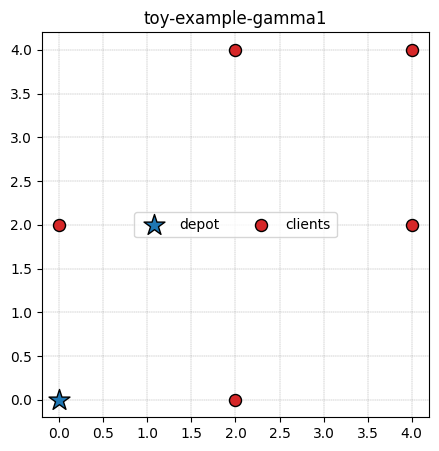

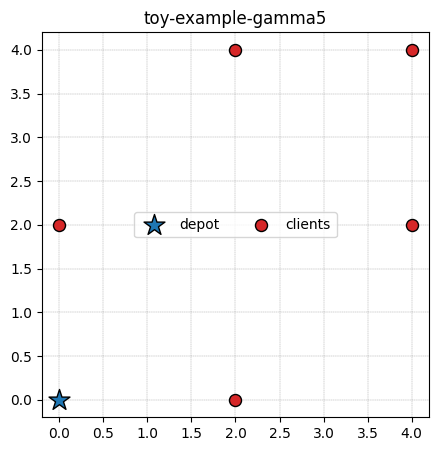

In [22]:
design = {
    'instance_idx': list(range(1)),
    'n_customers': [5],
    'service_distribution': ['uniform'],
    'distances_scv': [(0.1, 0.1)],
    'gamma': [1, 5],
}
for n_customers in design['n_customers']:
    for instance_idx in design['instance_idx']:
        for sd_idx, service_distribution in enumerate(design['service_distribution']):
            for d_idx, distances_scv in enumerate(design['distances_scv']):
                for gamma in design['gamma']:
                    instance_seed = 1 
                    name = f"toy-example-gamma{gamma}"

                    data = make_random(
                        seed=instance_seed, 
                        dim=n_customers+1, 
                        max_size=50, 
                        mean_service_time=15,
                        min_service_time=14,
                        service_distribution=service_distribution,
                        distances_scv_min=distances_scv[0],
                        distances_scv_max=distances_scv[1],
                        # service_scv_min=service_scv[0],
                        # service_scv_max=service_scv[1],
                        service_scv = [0, gamma, 0.8*gamma, 0.6*gamma, 0.4*gamma, 0.2*gamma],
                        name=name,
                        coords=np.array([(0, 0), (2, 0), (0, 2), (4, 2), (2, 4), (4, 4)]),
                    )

                    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
                    plot_instance(ax, data)

                    save_data(data, '../experiments/toy/instances')

NOTE: 
- TODO: Higher mean service times leads to longer running times